# Detecting Stock Market Anomalies Part 1:

<p>In trading as in life, it is often extremely valuable to determine whether or not the current environment is anomalous in some way. If things are acting "normal" we know our strategies can trade a certain way. For example, if we are in a normal trading environment we might employ a volatility shorting strategy. On the other hand, if we identify we are in an abnormally exciting market, it might behoove us to employ a strategy which does the exact opposite: seeking out opportunities for momentum based trading, for example. In that kind of market, shorting volatility could be very dangerous</p>
<p><a href = "http://www.slicematrix.com">SliceMatrix-IO</a> offers a number of different options for detecting anomalies on both univariate and multivariate datasets. Today we will explore an anomaly detection algorithm called an <b>Isolation Forest</b>. This algorithm can be used on either univariate or multivariate datasets. It has one parameter, <i>rate</i>, which controls the target rate of anomaly detection. I.e. a rate equal to 0.2 will train the algorithm to detect anomalies in 1 out of 5 datapoints on average. The rate must be greater than 0 and less than 0.5</p>
<p>Since the Isolation Forest can handle multivariate data, it is ideal for detecting anomalies when you have multiple input features. In our case, our input features will be the daily trading volume for a list of ETF symbols. We will define this microcosm as our "market" although in practice we could potential make the universe much, much bigger</p>

In [1]:
symbols = ['SPY', 'IWM', 'DIA', 'IEF', 'TLT', 'GLD', 'SLV', 'USO', 'XIV']

<p>The goal of this algo is to determine when the trading volume for our list of symbols <i> as a whole </i> is in an anomalous state. This could mean, for example, that we are detecting a spike in trading volume. To do this, we begin by importing the SliceMatrix-IO Python client. </p>
<p>If you haven't installed the client yet, the easiest way is with pip:</p>

<pre>
pip install slicematrixIO
</pre>

<p>Now we can begin by creating the SliceMatrix-IO client. Make sure to substitute your own api key into the code. <p>
<p>Don't have a key yet? <a href = "http://www.slicematrix.com">Get your api key here</a></p>

In [31]:
from slicematrixIO import SliceMatrix

api_key = "insert your api key here"
sm = SliceMatrix(api_key)

<p>Next let's import some useful Python modules such as Pandas, NumPy, and Pyplot</p>

In [4]:
%matplotlib inline
import pandas as pd
#import pandas.io.data as web
from pandas_datareader import data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt


<p>Grab trading volume data from Yahoo for our list of stocks using Pandas' Data-Reader</p>

In [20]:
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2017, 3, 6)

volume = []
closes = []
for symbol in symbols:
    print symbol
    vdata = web.DataReader(symbol, 'yahoo', start, end)
    cdata = vdata[['Close']]
    closes.append(cdata)
    vdata = vdata[['Volume']]
    volume.append(vdata)
    
volume = pd.concat(volume, axis = 1).dropna()
volume.columns = symbols
closes = pd.concat(closes, axis = 1).dropna()
closes.columns = symbols

SPY
IWM
DIA
IEF
TLT
GLD
SLV
USO
XIV


In [6]:
volume.head()

,SPY,IWM,DIA,IEF,TLT,GLD,SLV,USO,XIV
Date,,,,,,,,,
2012-01-03,193697900,60504700,7175100,1297700,9076900,13385800,28140300,12369900,5366800
2012-01-04,127186500,34648500,7625200,1789000,8417100,11549700,18062600,13812800,6686900
2012-01-05,173895000,57274600,8678900,1311300,6465800,11621600,13858900,11799600,4373600
2012-01-06,148050000,45499800,7488600,998200,7348500,9790500,20679500,9760600,5765800
2012-01-09,99530200,52042400,5881800,379900,5582400,8771900,11638200,7509300,3306600


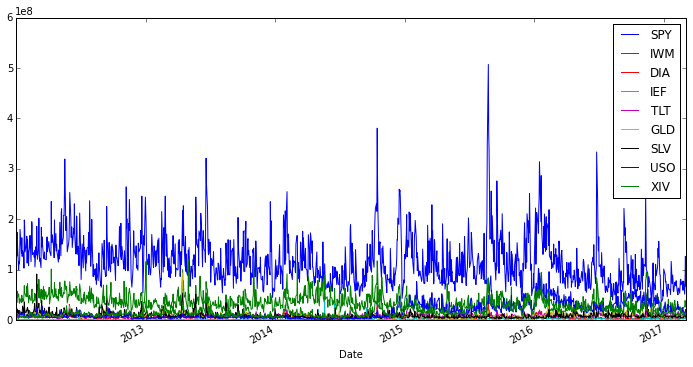

In [7]:
volume.plot(figsize=(12, 6))
plt.show()

<p>The time series of volume is has siginificant spikes in trading volume accross our ETF universe. Some notable events include the October 2014 Treasury Flash Crash, August 2015's spike in volatility, as well as Donald Trump's election in late 2016. Note the relative quiet in the start of 2017...</p>

<p>While these events are obvious to the naked eye (well after the fact) what would be useful is the ability to automatically classify events based purely off the trading volume data, i.e. without the use of a human being. This is the goal of machine learning, and luckily this is exactly the kind of use case our algo, the Isolation Forest, was built to handle</p>

<p>We'll start by creating 3 anomaly detectors with increasing values to the rate parameter. Remember, this controls how many anomalies each detector will pick up</p>

In [8]:
# isolation forest multivariate anomaly detector
iso_forest1 = sm.IsolationForest(dataset = volume, rate = 0.1)  # want signal every 1 / 10 days on average
iso_forest2 = sm.IsolationForest(dataset = volume, rate = 0.2)  # want signal every 1 / 5 days on average
iso_forest3 = sm.IsolationForest(dataset = volume, rate = 0.33) # want signal every 1 / 3 days on average

<p>These three models are now training and ready to be used in the cloud.</p>

<p>Now let's get the anomaly scores (i.e. whether or not the trading day was anomalous) from each model. The Isolation Forest returns a score of 1 for normal days and -1 for anomalous trading activity </p>

In [10]:
scores1 = iso_forest1.training_scores()
scores2 = iso_forest2.training_scores()
scores3 = iso_forest3.training_scores()
scores1 = pd.DataFrame(scores1, columns = ["scores"])
scores2 = pd.DataFrame(scores2, columns = ["scores"])
scores3 = pd.DataFrame(scores3, columns = ["scores"])

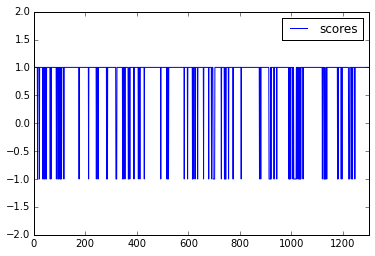

In [11]:
scores1.plot(ylim = (-2.0, 2.0))

In [12]:
print scores1.shape, volume.shape

(1300, 1) (1300, 9)


<p>Let's make a function to visualize the 3 dectectors performance</p>

In [13]:
import matplotlib.collections as collections

In [58]:
def draw_anomaly_plot(scores, volume, title, lw = 2):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title(title)

    ax.plot(scores.index.values, volume.sum(axis = 1), color='black')
    ax.axhline(0, color='black', lw=2)

    for i in range(0, scores.shape[0]):
        score = scores.ix[i]
        if score[0] < 0:
            l = plt.axvline(x=i, color='red', alpha=0.25, lw = lw)

    plt.show()

<p>Now we can compare the three models and visualize how the rate parameter is affecting the probablity of detecting an anomaly</p>

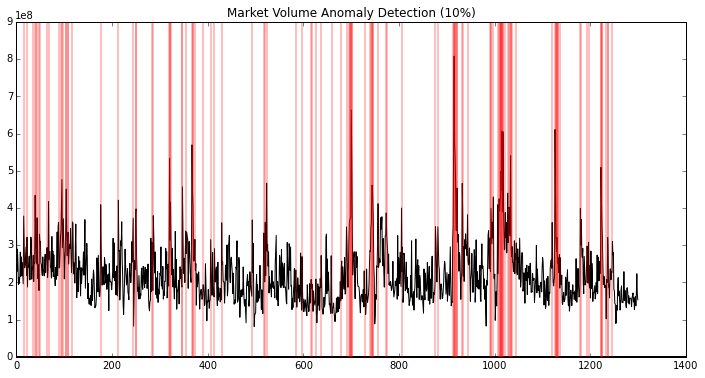

In [59]:
draw_anomaly_plot(scores1, volume, 'Market Volume Anomaly Detection (10%)')

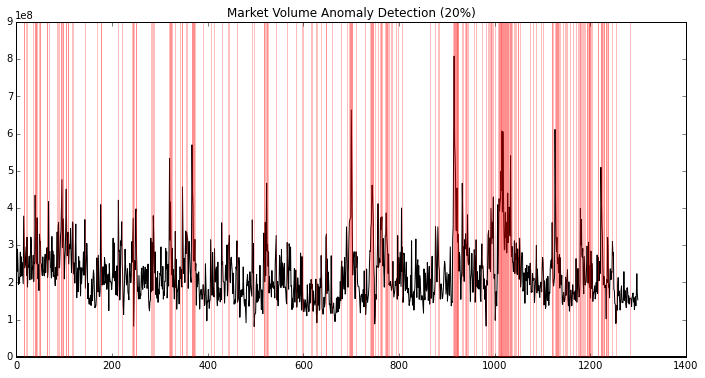

In [16]:
draw_anomaly_plot(scores2, volume, 'Market Volume Anomaly Detection (20%)')

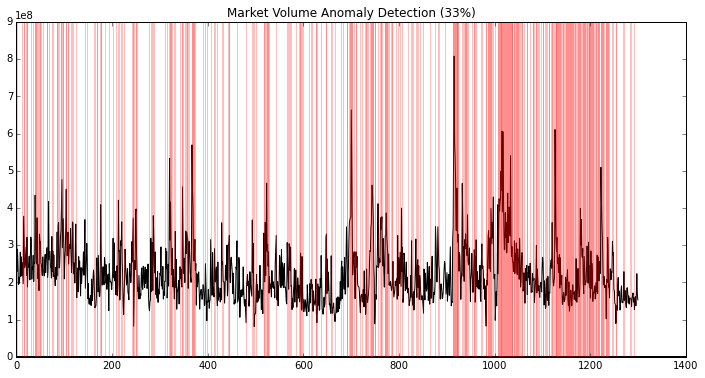

In [18]:
draw_anomaly_plot(scores3, volume, 'Market Volume Anomaly Detection (33%)')

<p>We can see how the number of anomalies detected increases as we ratchet up the rate parameter.</p>

<p>In the models we created above, we used the entire dataset to train our Isolation Forests. In practice, we don't have access to information in the future (at least not with current technology) so we should introduce some reality into our model by splitting the dataset into two chunks: one for training the model (in-sample) and one for validating the model's performance (out-sample)</p>

In [50]:
# split the dataset
volume_training = volume.ix[0:1200,:]
volume_testing  = volume.ix[1201:,:]

In [51]:
iso_forest_live_model = sm.IsolationForest(dataset = volume_training, rate = 0.2)

<p>This model is trained using only the volume_training dataframe. Now we can use this model to score the out of sample trading volume:</p>

In [52]:
out_of_sample_scores  = iso_forest_live_model.score(volume_testing.values.tolist())

In [53]:
out_of_sample_scores  = pd.DataFrame(out_of_sample_scores, columns = ['scores'])
out_of_sample_scores.tail()

,scores
94,1
95,1
96,1
97,1
98,1


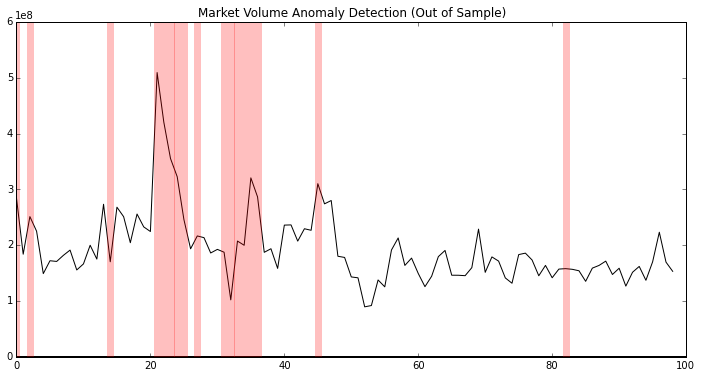

In [63]:
draw_anomaly_plot(out_of_sample_scores, volume_testing, 'Market Volume Anomaly Detection (Out of Sample)', lw = 7)

<p>One of the strength's of using <a href = "http://www.SliceMatrix.com/">SliceMatrix-IO</a> is that your models persist in the cloud after you train them, meaning you can load your models from any device anywhere on the planet with an internet connection.</p> 

<p>For example, suppose we have one process which trains the models (e.g. using the code above) and another process which runs during live trading which does the anomaly scoring. Each model has an attribute called name which describes the unique id for that model: </p>

In [64]:
print iso_forest_live_model.name

dad038cf1f1f


<p>We can easily load this model in another process using the lazy load feature:</p>

In [68]:
# in another process
iso_forest_live_model = sm.IsolationForest(name = "dad038cf1f1f")

# when we get a new data point we want to score...
iso_forest_live_model.score([[66650800, 30445200, 2580800, 2469300, 9460700, 10536000, 8681600, 13807500, 8518800]])

[1]

<p>This way you can use SliceMatrix-IO to easily and quickly create real time machine learning models for trading anywhere on the globe</p>